# Character Level RNN Tutorial

This follows the tutorial here: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

In [2]:
%matplotlib inline
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('dark_background')

In [3]:
files = glob.glob("/home/clarencenhuang/data/pytorch-tutorials/names/*.txt")

In [4]:
files[:3]

['/home/clarencenhuang/data/pytorch-tutorials/names/Spanish.txt',
 '/home/clarencenhuang/data/pytorch-tutorials/names/Polish.txt',
 '/home/clarencenhuang/data/pytorch-tutorials/names/Portuguese.txt']

### Text Normalization

In [5]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn' and c in all_letters)


def read_lines(fname):
    with open(fname, encoding='utf8') as fh:
        lines = fh.read().strip().split('\n')
        return list(map(unicode_to_ascii, lines))
    

In [6]:
unicode_to_ascii('Ślusàrski')

'Slusarski'

In [7]:
category_lines = {}
for fname in files:
    category = os.path.splitext(os.path.basename(fname))[0]
    category_lines[category] = read_lines(fname)
n_categories = len(category_lines.keys())
all_categories = sorted(category_lines.keys())
cat2idx = {c:i for i,c in enumerate(sorted(category_lines.keys()))}
idx2cat = {i:c for i,c in enumerate(sorted(category_lines.keys()))}

In [8]:
category_lines['Japanese'][:5]

['Abe', 'Abukara', 'Adachi', 'Aida', 'Aihara']

### Data Encoding

In [9]:
letter_to_idx = {c:i for i,c in enumerate(all_letters)}
idx_to_letter = {i:c for i,c in enumerate(all_letters)}

def letter2tensor(l):
    t = torch.zeros(1, n_letters)
    t[0, letter_to_idx[l]] = 1
    return t

def line2tensor(line):
    t = torch.zeros(len(line), 1, n_letters)
    for i in range(len(line)):
        l = line[i]
        t[i,:] = letter2tensor(l)
    return t

In [10]:
line2tensor("Jones").shape

torch.Size([5, 1, 57])

### Create a Recurrent NN

This is kind of a wierd RNN because it does

h1 = W_i2h (x + h0) + b_input
output = W_i2o (x + h0) + b_output


In [11]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, h):
        concat = torch.cat((x, h), 1)
        h1 = self.i2h(concat)
        o = self.i2o(concat)
        o = self.softmax(o)
        return o, h1  
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [12]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [13]:
inp = letter2tensor("A")
hidden = torch.zeros(1, n_hidden)
o, nh = rnn(inp, hidden)

Try on a line

In [14]:
inp = line2tensor("Nankun")
hidden = torch.zeros(1, n_hidden)
o, nh = rnn(inp[0], hidden)
o.shape

torch.Size([1, 18])

In [15]:
def category_from_output(o):
    idx = o.topk(1)[1].item()
    return idx2cat[idx], idx

In [16]:
category_from_output(o)

('French', 5)

In [17]:
def random_training_sample():
    category = np.random.choice(all_categories)
    line = np.random.choice(category_lines[category])
    category_tensor = torch.LongTensor([cat2idx[category]])
    line_tensor = line2tensor(line)
    return category, line, category_tensor, line_tensor

### Training Process

In [41]:
criterion = nn.NLLLoss()
cell = RNN(n_letters, n_hidden, n_categories)
optimizer = optim.Adam(cell.parameters(), lr=0.001)
epochs = 100000
def train(cell, epochs, optimizer, loss_every=5000):
    losses = []
    total_loss = 0
    cell.train()
    for e in range(epochs):
        _, _, cat_tensor, line_tensor = random_training_sample()
        optimizer.zero_grad()
        h = cell.init_hidden()
        for i in range(line_tensor.shape[0]):
            o, h = cell(line_tensor[i], h)
        
        loss = criterion(o, cat_tensor)
        loss.backward()
        #nn.utils.clip_grad_norm_(cell.parameters(), 10)
        optimizer.step()
        
        total_loss += loss.item()
        if (e+1) % loss_every == 0: 
            losses.append(total_loss/loss_every)
            print(f"epoch {e+1} running loss is {total_loss/loss_every}")
            total_loss = 0
    return losses

In [42]:
loss_hist_linear_rnn = train(cell, epochs, optimizer)

epoch 5000 running loss is 2.2332830371178685
epoch 10000 running loss is 1.7515948969412596
epoch 15000 running loss is 1.5879500095478667
epoch 20000 running loss is 1.4785837747845565
epoch 25000 running loss is 1.436006814744581
epoch 30000 running loss is 1.3859413547553063
epoch 35000 running loss is 1.365235902921528
epoch 40000 running loss is 1.3186918842134063
epoch 45000 running loss is 1.3102721575046794
epoch 50000 running loss is 1.2794245894160663
epoch 55000 running loss is 1.2519506378198115
epoch 60000 running loss is 1.2673598964395656
epoch 65000 running loss is 1.2523416754180685
epoch 70000 running loss is 1.2304190665956167
epoch 75000 running loss is 1.2260748353886837
epoch 80000 running loss is 1.242722384023421
epoch 85000 running loss is 1.198996474925802
epoch 90000 running loss is 1.2133160466290542
epoch 95000 running loss is 1.2092426223442199
epoch 100000 running loss is 1.1700460314193228


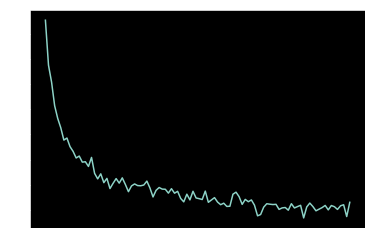

In [20]:
plt.plot(loss_hist_linear_rnn)

In [21]:
_,_,ct,lt = random_training_sample()
o,_ = cell(lt[0],cell.init_hidden())
torch.exp(o).sum(), o

(tensor(1.),
 tensor([[-3.0466, -2.8870, -2.4564, -2.7718, -2.4537, -2.6538, -2.4075,
          -4.0620, -2.9120, -3.3345, -3.4477, -2.5908, -3.2039, -3.2533,
          -2.9916, -2.7599, -3.0756, -3.0131]]))

In [22]:
def evaluate(cell, x):
    if isinstance(x, str):
        x = line2tensor(x)
    cell.eval()
    h = torch.zeros(1, n_hidden)
    for i in range(x.shape[0]): 
        o, h = cell(x[i], h)
    return category_from_output(o)

In [23]:
def show_confusion(cell):
    confusion = np.zeros((n_categories, n_categories))
    n_confusion = 10000
    for i in range(n_confusion):
        category, _, _, line_tensor = random_training_sample()
        _, idx = evaluate(cell, line_tensor)
        confusion[cat2idx[category], idx] += 1
    confusion = confusion / confusion.sum(axis=1)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + all_categories, rotation=90)
    ax.set_yticklabels([''] + all_categories)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()

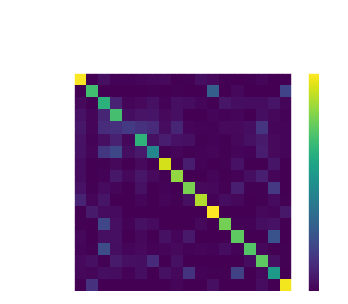

In [24]:
show_confusion(cell)

### Exercise 1, try training this stuff on a torch.RNN cell which has a nonlinearity

In [28]:
class WordRNN(nn.Module):
    
    def __init__(self, n_input, n_hidden, n_output):
        super(WordRNN, self).__init__()
        self.rnn_cell = nn.RNNCell(n_input, n_hidden)
        self.h2o = nn.Linear(n_hidden, n_output)
    
    def forward(self, x, h):
        h = self.rnn_cell(x, h)
        o = self.h2o(h)
        return o, h
    
    def init_hidden(self):
        zeros = torch.zeros(1, n_hidden)
        if next(self.parameters()).is_cuda:
            zeros = zeros.cuda()
        return zeros

In [29]:
def train_rnn(cell, optimizer, criterion, epochs, print_every=5000):
    cell.train()
    tloss = 0
    losses = []
    for e in range(0, epochs):
        _, _, cat_tensor, line_tensor = random_training_sample()
        cat_tensor, line_tensor = cat_tensor.cuda(), line_tensor.cuda()
        optimizer.zero_grad()
        h = cell.init_hidden()
        for t in range(line_tensor.shape[0]):
            o, h = cell(line_tensor[t], h)
        output = F.log_softmax(o, dim=1)
        loss = criterion(output, cat_tensor)
        loss.backward()
        optimizer.step()
        
        tloss += loss.item()
        if e > 0 and e % print_every == 0:
            print(f"epoch: {e} loss: {tloss/print_every}")
            losses.append(tloss/print_every)
            tloss = 0
    return losses

In [30]:
cell = WordRNN(n_letters, n_hidden, n_categories)
cell.cuda()
criterion = nn.NLLLoss()
optimizer = optim.Adam(cell.parameters(), lr=0.001)
epochs = 100000
loss_hist_rnn = train_rnn(cell, optimizer, criterion, epochs)

epoch: 5000 loss: 2.1197241476535797
epoch: 10000 loss: 1.6325877628326415
epoch: 15000 loss: 1.52160219540596
epoch: 20000 loss: 1.4585292829990386
epoch: 25000 loss: 1.3324082176923753
epoch: 30000 loss: 1.2538191477298737
epoch: 35000 loss: 1.1993853785037993
epoch: 40000 loss: 1.1207513904809951
epoch: 45000 loss: 1.0851177055358887
epoch: 50000 loss: 1.00753974943161
epoch: 55000 loss: 0.9842211889743805
epoch: 60000 loss: 0.9053865931272507
epoch: 65000 loss: 0.9457616463899613
epoch: 70000 loss: 0.8868020311832427
epoch: 75000 loss: 0.8417879786968231
epoch: 80000 loss: 0.8844132354021073
epoch: 85000 loss: 0.8914319610357284
epoch: 90000 loss: 0.8692208408117295
epoch: 95000 loss: 0.90298882791996


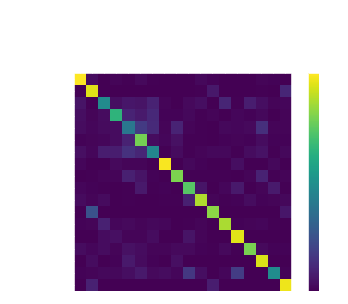

In [32]:
cell.cpu()
show_confusion(cell)

In [33]:
evaluate(cell, "Ahn")

('Korean', 11)

### Lets try a GRU 

In [34]:
class WordGRU(nn.Module):
    
    def __init__(self, n_input, n_hidden, n_output):
        super(WordGRU, self).__init__()
        self.rnn_cell = nn.GRUCell(n_input, n_hidden)
        self.h2o = nn.Linear(n_hidden, n_output)
    
    def forward(self, x, h):
        h = self.rnn_cell(x, h)
        o = self.h2o(h)
        return o, h
    
    def init_hidden(self):
        zeros = torch.zeros(1, n_hidden)
        if next(self.parameters()).is_cuda:
            zeros = zeros.cuda()
        return zeros

In [35]:
cell = WordGRU(n_letters, n_hidden, n_categories)
cell.cuda()
criterion = nn.NLLLoss()
optimizer = optim.Adam(cell.parameters(), lr=0.001)
epochs = 100000
loss_hist_gru = train_rnn(cell, optimizer, criterion, epochs)

epoch: 5000 loss: 1.9183378880500794
epoch: 10000 loss: 1.303934335923195
epoch: 15000 loss: 1.1052218922615051
epoch: 20000 loss: 0.9645266226768494
epoch: 25000 loss: 0.8240475368499756
epoch: 30000 loss: 0.6960304815530777
epoch: 35000 loss: 0.6277269144296647
epoch: 40000 loss: 0.5498600326538086
epoch: 45000 loss: 0.5091751786231995
epoch: 50000 loss: 0.45587268295288086
epoch: 55000 loss: 0.4492471991300583
epoch: 60000 loss: 0.40861341915130617
epoch: 65000 loss: 0.3889452942609787
epoch: 70000 loss: 0.3817923135995865
epoch: 75000 loss: 0.37420001049041746
epoch: 80000 loss: 0.35677362344264985
epoch: 85000 loss: 0.34157834343910215
epoch: 90000 loss: 0.3323266980648041
epoch: 95000 loss: 0.33474703347682955


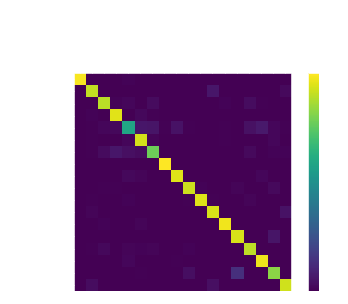

In [36]:
cell.cpu()
show_confusion(cell)

In [37]:
evaluate(cell, "nankun")

('Russian', 14)

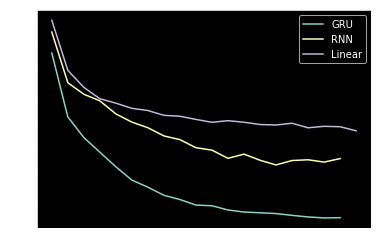

In [43]:
plt.plot(loss_hist_gru)
plt.plot(loss_hist_rnn)
plt.plot(loss_hist_linear_rnn)
plt.legend(['GRU', 'RNN', 'Linear'])